# <center>Predicting Homelessness from Evictions in Los Angeles</center>
## <center>Samantha Gordon Danner</center>
### <center>August 2019</center>

## Project Background
<p>Homelessness in Los Angeles is at a crisis stage, with the number of people experiencing homelessness at an all-time high. Homelessness and housing advocates believe that the main forces behind the increase in homelessness are <a href="https://www.lahsa.org/documents?id=3437-2019-greater-los-angeles-homeless-count-presentation.pdf">a lack of affordable housing</a> and <a href="https://www.latimes.com/politics/la-pol-ca-new-home-building-goal-governor-candidates-20180306-story.html">too little available housing stock</a>, resulting in skyrocketing rental and home prices.</p>
<p>Many unhoused Angelenos, especially those experiencing their first episode of homelessness, cite <a href="https://www.lamag.com/citythinkblog/homeless-count-2019/">economic factors</a> as the main reason they are experiencing homelessness. In order to prevent more people from becoming homeless, advocates have recommended implementing policies such as a livable minimum wage and increased protections for renters like rent stabilization and "<a href="https://www.latimes.com/opinion/editorials/la-ed-right-to-counsel-eviction-lawyers-20190423-story.html">right to counsel</a>" for tenants facing eviction. While some progress has been made regarding the <a href="https://www.theeastsiderla.com/news/business/l-a-minimum-wage-workers-get-a--an-hour/article_fb604fae-9c19-11e9-85e6-9bf2ce97b7eb.html">minimum wage</a> and <a href="https://www.latimes.com/politics/la-pol-ca-california-renter-protection-bills-20190529-story.html">rent increase protections</a>, one issue that remains largely unchecked by local policy is evictions.</p>
<p>Although Los Angeles has a relatively <a href="https://la.curbed.com/2018/4/16/17235096/los-angeles-evictions-how-many-2016">low rate of  <i>formal</i> evictions</a> for a city of its size, it can be difficult to to determine how many people are truly affected by eviction, especially in cases of 'informal' evictions that do not go through a court. Recent reporting has shown that there is a <a href="https://evictionlab.org/map/">connection</a> between evictions and homelessness in Los Angeles, but determining whether evictions directly contribute to homelessness is a challenge, because there is very little data about what happens to people after an eviction. The objective of this project, then, is to use data science techniques to probe the relationship between evictions and homelessness in LA. The desired outcome of this information is to make public policy recommendations to local government, and to recommend effective strategies to real estate developers and investors, landlords, and building manager that will reduce homelessness in Los Angeles as expediently as possible.</p>

## Data Ingestion
<p>The data for this project comes from three sources:<p>
    <ul>
        <li><a href="https://economicrt.org/publication/los-angeles-county-homeless-count-data-library/">Economic Roundtable</a></li>
        <ul>
            <li>Los Angeles Homeless Street Count Data, 2007, 2009, 2011, 2013</li>
            <li>Los Angeles Homeless Count Adult Demographic Survey, 2011--2019</li>
        </ul>
        <li><a href="https://www.lahsa.org/dashboards">Los Angeles Homeless Services Authority</a>
        <ul>
            <li>Los Angeles Homeless Street Count Data, 2015--2019</li>
        </ul>
        </li>
        <li><a href="https://evictionlab.org/map/">The Eviction Lab at Princeton University</a></li>
        <ul>
            <li>Los Angeles Eviction Data, 2000--2016</li>
        </ul>
    </ul>
    
<p>For each source, data was available at the level of individual census tracts and analyses were performed at the level of census tracts for the majority of this data. Homeless Street Count and Evictions data were combined on year and census tract, but in many cases, especially in pre-2015 Homeless Street Count data, information is not available from every LA County census tract. In addition, the Homeless Street count was only performed biennially from 2007 to 2015, and public data on the Homeless Street Count is not available from years prior to 2007. The Eviction Lab's eviction data is only available for years from 2000 to 2016. Thus, one major challenge in this project was to find enough overlapping eviction and homelessness data from which to draw conclusions.</p>
<p>N.B.: Original Homeless Street Count data was collected using different methodologies and categories from year to year, and particularly before 2015, the count only covered a sample of census tracts. Homeless Street Count data were therefore pre-processed and only those categories using consistent methodology were included in the excel file that is imported below. Especially for earlier data, some categories may be altogether missing or may be renamed to be (approximately) consistent with more standard names.</p>

In [1]:
#package imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from ipywidgets import widgets
import altair as alt
import geopandas as gpd
import json
import requests

In [2]:
#initial homelessness and evictions datasets
hmlslink = 'https://github.com/samgordan/CapstoneProject/raw/master/Data/Homelessness/homelessnessdata2007-2019.xlsx'
homelessness = pd.read_excel(hmlslink, header=0)
evctnlink = 'https://github.com/samgordan/CapstoneProject/raw/master/Data/Evictions/LACEvictionsByTract.xlsx'
evictions = pd.read_excel(evctnlink, header=0)

In [3]:
#drop unused columns from Evictions dataset
cln_evictions = evictions.drop(['name', 'parent-location', 'low-flag', 'pct-white', 'pct-af-am', 'pct-hispanic', 'pct-am-ind', 'pct-asian', 'pct-nh-pi', 'pct-multiple', 'pct-other', 'imputed', 'subbed'], axis=1)

(39888, 14)

In [4]:
"""make a new column in Evictions data called new_tract that contains only the last 6 digits
of the original GEOID column; column will be used for matching in next step""" 
cln_evictions['new_tract'] = cln_evictions['GEOID']%1000000

In [5]:
#merge Homelessness and Evictions dataframes on year and tract number (outer merge)
comboHE = pd.merge(homelessness, cln_evictions,  how='outer', 
                   left_on=['Year','tractNum'], right_on = ['year','new_tract'])

In [6]:
#calculate homelessness rate using the total unhoused count / population * 100 for each census tract/year
comboHE['homeless_rate'] = (comboHE['totalUnshelteredPeopleCount']/comboHE['population'])*100

## Data Analysis
<p>Before analyzing this data in more complex ways, one thing to check is how evictions and homelessness have changed over the years each data source is available. The basic expectation is that both measures will have increased. Likewise, it is expected that the rate of evictions (# of evictions/# of rental households in a census tract) and the rate of homelessness (# of unhoused population/total population in a census tract) will have increased.</p>

Text(0, 0.5, 'Total # Unsheltered People')

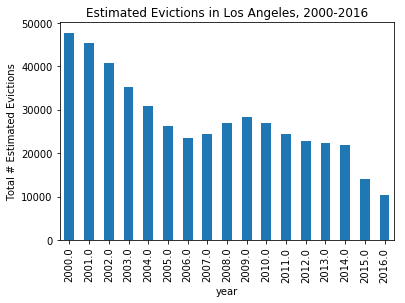

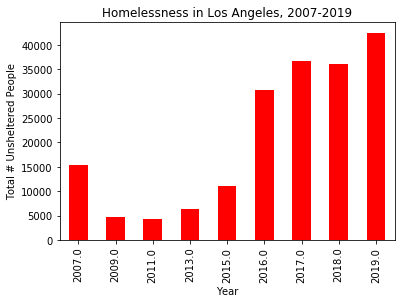

In [7]:
#Total estimated evictions by year plot
evictionsbyyear = comboHE.groupby(['year'])[["evictions"]].sum()
evctnplot = evictionsbyyear.plot.bar(title='Estimated Evictions in Los Angeles, 2000-2016',
                                     xlim=(2000,2016), legend=False)
evctnplot.set_ylabel('Total # Estimated Evictions')

#Total Unsheltered People by year plot
homelessnessbyyear = comboHE.groupby(['Year'])[["totalUnshelteredPeopleCount"]].sum()
hmlsplot = homelessnessbyyear.plot.bar(title='Homelessness in Los Angeles, 2007-2019', color='r', legend=False)
hmlsplot.set_ylabel("Total # Unsheltered People")

In [8]:
#create dataset to plot homelessness rate (note total population in census tract only available through 2016)
hmlsrate = comboHE[['homeless_rate', 'Year']].copy()
hmlsrate = hmlsrate.replace([np.inf, -np.inf], np.nan)
hmlsrateNArm = hmlsrate.dropna()

Text(0, 0.5, 'Mean Homelessness Rate')

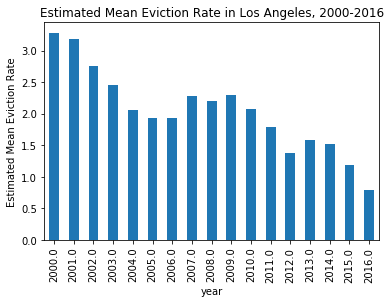

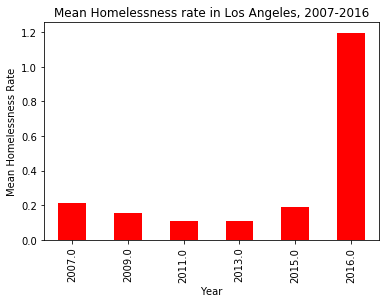

In [9]:
#Mean Eviction rate by year plot
evictionratebyyear = comboHE.groupby(['year'])[["eviction-rate"]].mean()
evctnrateplot = evictionratebyyear.plot.bar(title='Estimated Mean Eviction Rate in Los Angeles, 2000-2016', xlim=(2000,2016), legend=False)
evctnrateplot.set_ylabel('Estimated Mean Eviction Rate')

#Mean Homelessness Rate by year plot
homelessratebyyear = hmlsrateNArm.groupby(['Year'])[["homeless_rate"]].mean()
hmlsrateplot = homelessratebyyear.plot.bar(title='Mean Homelessness rate in Los Angeles, 2007-2016', color='r', legend=False)
hmlsrateplot.set_ylabel("Mean Homelessness Rate")

<p>One surprise we see from these very simple plots is that evictions and the eviction rate have generally decreased over time. Returning to <a href="https://evictionlab.org/help-faq/#low-rate">the Eviction Lab website FAQ</a>, it is noted that "In California, many cases that end in eviction are sealed and therefore not accessible by the general public. In addition, it can be difficult to collect data from California as a whole, owing to restrictions on the number of records one can collect." It is also possible, as noted earlier, that informal and no-fault evictions (particularly <a href="https://hcidla.lacity.org/Ellis-Act">Ellis Act evictions</a>) may be undercounted or not accurately represented in Eviction Lab data.</p>
<p>Another somewhat surprising result in the Homelessness data is the inconsistency of the increases in homelessness from year to year. One explanation for this may be the changes in methodology used for data collection over time. For example, there is a decrease in the number of unsheltered people and the mean homelessness rate between 2007 and 2009, but this is unlikely to reflect an <i>actual</i> decrease; rather it is likely due to a methodological change to avoid including imputed data in 2009. After 2015, the total number of unsheltered people and the homelessness rate drastically increases. Again, this may be due to a methodological change rather than an actual increase of such a large magnitude. There is also a slight decrease in the 2018 Homelessness numbers, which may again be attributed to methodological changes rather than an actual decrease, or it may be attributed to the fact that LA County did a better job of re-housing people in 2018, according to <a href="https://www.lahsa.org/documents?id=3437-2019-greater-los-angeles-homeless-count-presentation.pdf">LAHSA</a>.</p>
<p>Now that we have some sense for how evictions and homelessness counts and rates change over time in all of LA, let's plot the relationship between eviction rate and homelessness rate for the years when there is overlapping eviction and homelessness data.</p>

In [10]:
#remove missing values to create a dataset with evictions and homelessness data for overlapping years only
EH_NArm = comboHE.dropna(subset=['evictions','totalUnshelteredPeopleCount'])

Text(0.5, 1.0, 'Eviction Rate vs. Homelessness Rate by Census Tract, 2007 - 2016')

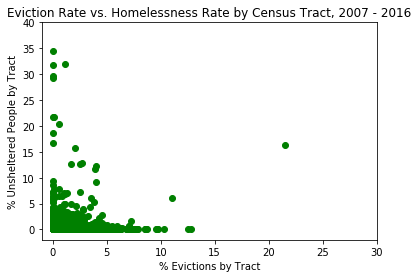

In [11]:
plt.plot(EH_NArm['eviction-rate'], EH_NArm['homeless_rate'],'o', color='green')
plt.xlim(-1,30)
plt.xlabel('% Evictions by Tract')
plt.ylim(-2,40)
plt.ylabel('% Unsheltered People by Tract')
plt.title('Eviction Rate vs. Homelessness Rate by Census Tract, 2007 - 2016')

<p>Although it was expected that evictions and homelessness would be positively correlated, no obvious correlation is apparent in the above scatterplot. If anything, areas with no evictions also show surprisingly high rates of homelessness. It is possible that in census tracts with very high homeless populations, like Skid Row, there are relatively few evictions, because the area is primarily a business district with few rental properties. It is also possible that evicted people do not immediately become homeless and thus a high eviction rate might not correlate with a high homelessness rate in the same census tract in the same year. Lastly, it may be that evicted people do not stay in the area they used to live as tenants; instead, they may move to find housing/shelter in other areas.</p>

### Does census tract similarity matter?
<p>Another consideration with this data is that evictions and homelessness are not evenly distributed across all census tracts of a city. For example, certain areas have a higher renter population and are therefore more likely to have higher eviction numbers. Other areas, like Downtown LA's Skid Row, have especially high concentrations of people experiencing homelessness. To handle these possibilities, an earlier version of this project (see 'CapstoneProjectDataSetup.ipynb') grouped some demographic metrics, such as percentage of renting households and poverty rate within a census tract, into low/medium/high categories to see whether stronger relationships between evictions and homelessness existed within certain categories of this data. Ultimately, this approach did not demonstrate any stronger or more obvious correlations between evictions and homelessness, so it is not discussed futher here.</p>

## Machine Learning Models

<p>Though correlation between a variety of measures and homelessness by census tracts was inconclusive in the previous exploratory analysis, this section applies machine learning to determine whether some relationship between evictions and homelessness may nonetheless be present.</p>

In [12]:
#drop weird eviction rate numbers
EH_NArm = EH_NArm[EH_NArm['eviction-rate']<=100]

In [13]:
EH_ml_data = EH_NArm.drop(['adultsCount', 'youthCount', 'totalFamiliesCount', 'carsCount', 
                            'vansCount', 'campersCount', 'tentsCount', 'otherShelterCount', 
                            'totalUnshelteredPeopleCount', 'GEOID', 'year', 'eviction-filings',
                            'eviction-filing-rate', 'new_tract'], axis=1)

In [14]:
EH_ml_data = EH_ml_data.astype(np.float32)

In [15]:
EH_ml_data_cln = EH_ml_data[~EH_ml_data.isin([np.nan, np.inf, -np.inf])]
EH_ml_data_cln = EH_ml_data_cln.dropna()

In [16]:
#create dataframe with continuous X variables
eviction_data_continuous_X_df = EH_ml_data_cln.drop(['homeless_rate'], axis=1)

EH_NArm_dict = eviction_data_continuous_X_df.to_dict()

In [17]:
#create data frame with just Y (homeless rate)
homeless_rate_Y = pd.Series(EH_ml_data_cln['homeless_rate'])

In [18]:
eviction_data_continuous_X_dict = {k: EH_NArm_dict[k] for k in ('Year', 'tractNum',
                                                'population', 'poverty-rate', 'renter-occupied-households',
                                                'pct-renter-occupied', 'median-gross-rent', 'median-household-income',
                                                'median-property-value', 'rent-burden', 'evictions', 'eviction-rate')}
eviction_data_continuous_X_list = eviction_data_continuous_X_df.values.tolist()

In [19]:
X_names = [key for key, value in eviction_data_continuous_X_dict.items()]
X_data = [value for key, value in eviction_data_continuous_X_dict.items()]

X_data_dict = dict(zip(X_names, ['Year', 'Census Tract', 'Total Population',
                                 'Poverty Rate', 'Renter Households Count', 'Renter Households %', 'Median Gross Rent',
                                 'Median Household Income', 'Median Property Value', 'Rent Burden', 'Eviction Count', 
                                 'Eviction Rate']))


X_data_df = pd.DataFrame(eviction_data_continuous_X_list, columns=X_names)

In [20]:
#shuffle data
X_data_df, homeless_rate_Y = shuffle(X_data_df, homeless_rate_Y)

In [21]:
#create graph of various continuous explanatory factors vs. homelessness.
def EH_NArm_plot(column):
    plt.plot(X_data_df[column], homeless_rate_Y, '.')
    plt.ylim(0,100)
    plt.xlabel(X_data_dict[column])
    plt.ylabel('Homelessness rate (% of population in census tract)')

dropdown_values = {"{0}: {1}".format(k, v):k for k, v in X_data_dict.items()}

widgets.interact(EH_NArm_plot, column=dropdown_values)

interactive(children=(Dropdown(description='column', options={'Year: Year': 'Year', 'tractNum: Census Tract': …

<function __main__.EH_NArm_plot(column)>

### Linear Regression
<p>Although no obvious linear relationships existed in the explanatory factors vs. Homelessness rate above, the following creates a model using linear regression to check whether multiple explanatory factors do any better at explaining the homelessness rate.</p>

In [22]:
#make imputer and scaler for pipeline below
imp = SimpleImputer(strategy='median')
scaler = StandardScaler()
linreg = LinearRegression() 

In [23]:
#build a linear regression pipeline
continousvar_pl = Pipeline([
        #imputer
    ('imp', imp),
        #standard scaler
    ('ss', scaler),
        #Linear Regressor
    ('lr', linreg)
])

In [24]:
#need to cast data to float64 to work with pipeline
X_data_df = X_data_df.astype('float64')
homeless_rate_Y = homeless_rate_Y.astype('float64')

In [25]:
#create a train-test split on all features and output before to get a score later on
contvar_train, contvar_test, y_train, y_test = train_test_split(X_data_df,
                                                                homeless_rate_Y, test_size=0.3, random_state=42)

In [26]:
#first try a linear regression with *just* evictions (count) predicting homelessness rate
X_evictions = contvar_train[['evictions']]

Text(0, 0.5, 'Homelessness Rate')

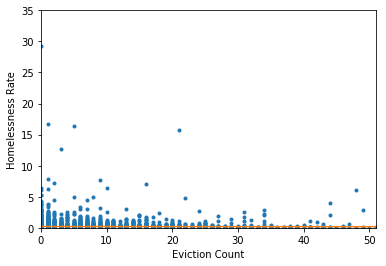

In [27]:
#run a linear regression on evictions predicting homelessness rate
linreg = LinearRegression(fit_intercept=True)
linreg.fit(X_evictions, y_train)
x = np.linspace(-1, 51, 50).reshape(-1,1)

#plot a linear regression on evictions predicting homelessness rate
plt.plot(X_evictions, y_train, '.')
plt.plot(x, linreg.predict(x), '-')
plt.ylim(0, 35)
plt.xlim(0, 51)
plt.xlabel(X_data_dict['evictions'])
plt.ylabel('Homelessness Rate')

In [28]:
#get scores and mean score for evictions -> homelessness
scores = cross_val_score(linreg, X_evictions, y_train, cv=5)
print(scores, scores.mean())

[-0.00034714 -0.00086247 -0.00058539 -0.00033334 -0.00294125] -0.0010139189294236406


In [29]:
#now run a regression with all the predictor variables
continousvar_pl.fit(contvar_train, y_train)

Pipeline(memory=None,
     steps=[('imp', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)), ('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lr', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

In [30]:
#get scores and mean score for all predictors -> homelessness
scores = cross_val_score(continousvar_pl, contvar_test, y_test, cv=10)
print(scores, scores.mean())

[ 0.00233046 -0.04932084 -0.08507087  0.0209697  -0.00550757  0.00365884
  0.03899108  0.00659947 -0.45452828  0.08576519] -0.04361128257055382


### Random Forest Regression

<p> As linear regression proved to be a poor choice for describing this data set, the next step is to try again with another type of regressor. This time we will use a Random Forest Regressor and the same data set.</p>

In [31]:
#create Random Forest Regressor Pipeline
rfr = RandomForestRegressor(n_estimators=100)
rfpipeline = Pipeline([
    #imputer
    ('imp', imp),
    #standard scaler
    ('ss', scaler),
    #Random Forest Regressor
    ('rfr', rfr)
])

In [32]:
#run data through pipeline
rfpipeline.fit(contvar_train, y_train)

Pipeline(memory=None,
     steps=[('imp', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)), ('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rfr', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_lea...tors=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])

In [33]:
#print all scores and mean score for Random Forest Regression predicting homelessness rate in LA
rfr_scores = cross_val_score(rfpipeline, contvar_test, y_test, cv=10)
print(rfr_scores, rfr_scores.mean())

[ 3.72392524e-02 -3.21749981e+00  7.22137319e-02 -7.53894043e-01
 -3.88438836e+00 -5.72695991e-03  2.73770931e-02  5.18173862e-01
 -1.65693959e+01  3.78876962e-01] -2.3397024148877197


## Visualizations
<p>Another matter of interest in this research is understanding how homelessness in Los Angeles has changed over time. Prior to 2015, homelessness in LA was largely concentrated in a few areas such as Skid Row. In recent years, homelessness has become more widespread, with greater numbers of people living unsheltered in various areas throughout the city. Below, choropleth maps visualize how homelessness in Los Angeles has changed over time, at the levels of census tracts and ZIP codes.</p>

<p>First we will make a dataframe of data for mapping, and merge it with ZIP code data.</p>

In [34]:
#zip code to census tract mapping
ziplink = 'https://github.com/samgordan/CapstoneProject/raw/master/Data/Evictions/zips_tracts.xlsx'
zips = pd.read_excel(ziplink, header=0)
zips['tractNum'] = zips['TRACT']%1000000

In [35]:
#add zip codes for census tract (note that some census tracts may have multiple zip codes. only use the first?)
comboHE = pd.merge(comboHE, zips, on=['tractNum'], how='left', validate='m:1')

In [36]:
comboHE.drop(['TRACT'], axis=1, inplace=True)

In [37]:
mapdata = comboHE[['Year', 'tractNum', 'totalUnshelteredPeopleCount', 'poverty-rate', 'homeless_rate', 'rent-burden',
                        'evictions', 'eviction-rate','ZIP']].copy()

<p>Next, we will load GEOJSON shape files with Los Angeles Census Tract boundaries and ZIP code boundaries, which will be used to build choropleth maps.</p>

In [38]:
#LA census tracts shape file
census_shape = "/Users/sgd/Dropbox/Documents/DataIncubator/CapstoneProject/Scripts/census-tracts-2012/LA_censusTract_2012.shp"
#LA zip codes shape file
zip_shape = '/Users/sgd/Dropbox/Documents/DataIncubator/CapstoneProject/Scripts/CAMS_ZIPCODE_PARCEL_SPECIFIC/CAMS_ZIPCODE_PARCEL_SPECIFIC.shp'

In [39]:
#make base map of census tracts
map_census = gpd.read_file(census_shape)

In [40]:
#make base map of zip codes
map_zip = gpd.read_file(zip_shape)

In [41]:
#separate map data by year
mapdata_2007 = mapdata[mapdata['Year'] == 2007.0]
mapdata_2009 = mapdata[mapdata['Year'] == 2009.0]
mapdata_2011 = mapdata[mapdata['Year'] == 2011.0]
mapdata_2013 = mapdata[mapdata['Year'] == 2013.0]
mapdata_2015 = mapdata[mapdata['Year'] == 2015.0]
mapdata_2016 = mapdata[mapdata['Year'] == 2016.0]
mapdata_2017 = mapdata[mapdata['Year'] == 2017.0]
mapdata_2018 = mapdata[mapdata['Year'] == 2018.0]
mapdata_2019 = mapdata[mapdata['Year'] == 2019.0]

In [42]:
#make tract in census tracts shape file matchable
map_census['tractNum'] = pd.to_numeric(map_census['TRACTCE'], downcast='float')

In [43]:
#make ZIP in Zip code shape file matchable
map_zip['ZIP'] = pd.to_numeric(map_zip['ZIPCODE'], downcast='float')

In [44]:
#sum homeless count by ZIP code
zipgroup_2007 = mapdata_2007.groupby(['ZIP'])[["totalUnshelteredPeopleCount"]].sum()
zipgroup_2009 = mapdata_2009.groupby(['ZIP'])[["totalUnshelteredPeopleCount"]].sum()
zipgroup_2011 = mapdata_2011.groupby(['ZIP'])[["totalUnshelteredPeopleCount"]].sum()
zipgroup_2013 = mapdata_2013.groupby(['ZIP'])[["totalUnshelteredPeopleCount"]].sum()
zipgroup_2015 = mapdata_2015.groupby(['ZIP'])[["totalUnshelteredPeopleCount"]].sum()
zipgroup_2016 = mapdata_2016.groupby(['ZIP'])[["totalUnshelteredPeopleCount"]].sum()
zipgroup_2017 = mapdata_2017.groupby(['ZIP'])[["totalUnshelteredPeopleCount"]].sum()
zipgroup_2018 = mapdata_2018.groupby(['ZIP'])[["totalUnshelteredPeopleCount"]].sum()
zipgroup_2019 = mapdata_2019.groupby(['ZIP'])[["totalUnshelteredPeopleCount"]].sum()

In [45]:
# list of years (which are the column names at the moment)
zipbyyear_list = [zipgroup_2007, zipgroup_2009, zipgroup_2011, zipgroup_2013, zipgroup_2015,
                  zipgroup_2016, zipgroup_2017,zipgroup_2018, zipgroup_2019]

In [46]:
# set the min and max range for the choropleth map
vmin, vmax = 0.0, 200.0
#name variable
variable = 'totalUnshelteredPeopleCount'
yearlist = ['2007', '2009', '2011', '2013', '2015', '2016', '2017', '2018', '2019']

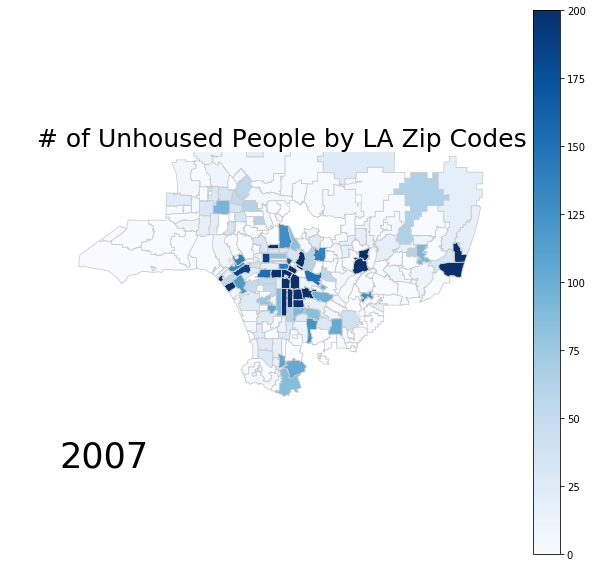

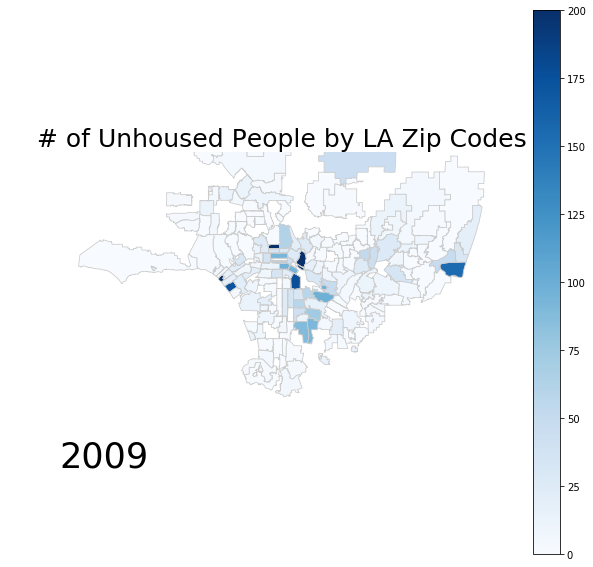

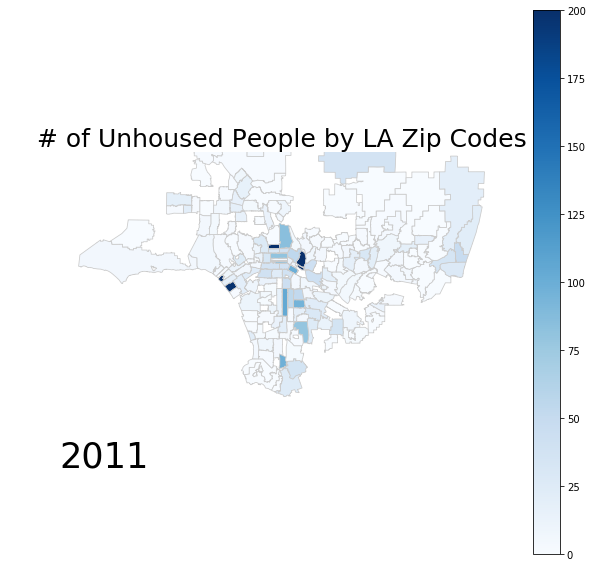

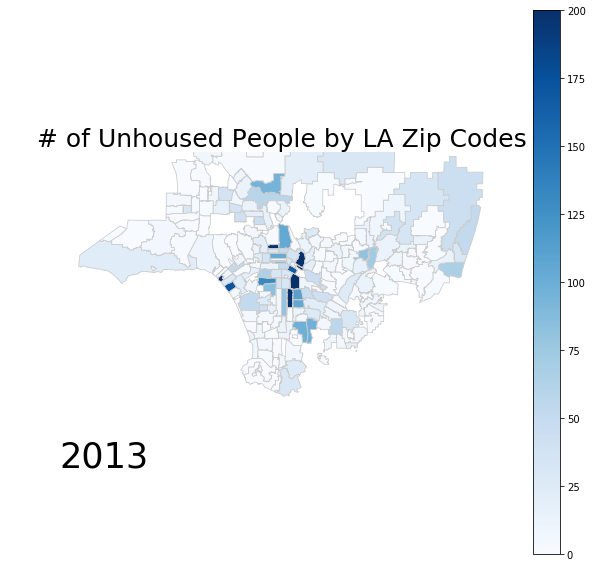

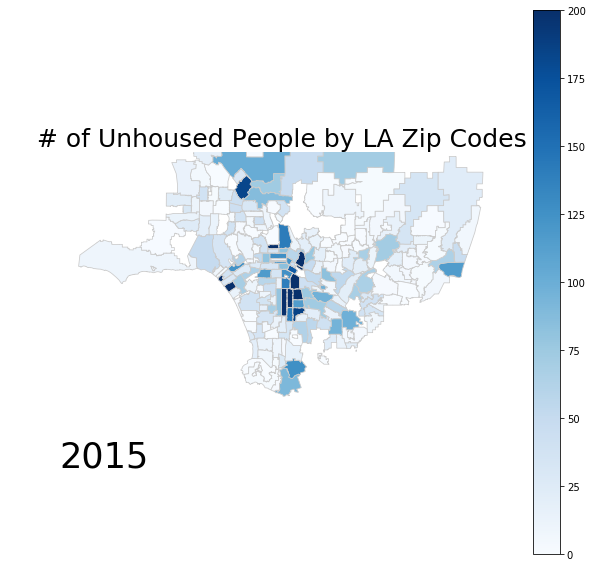

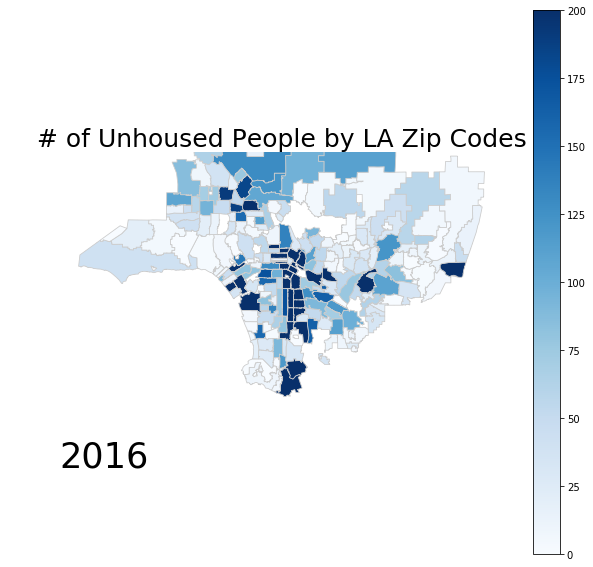

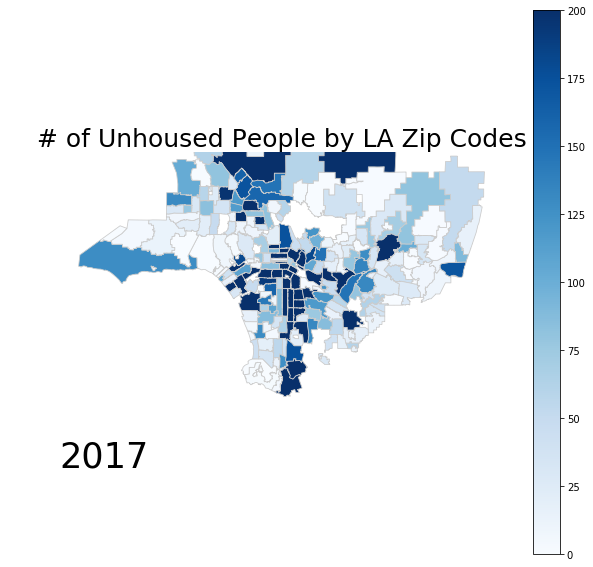

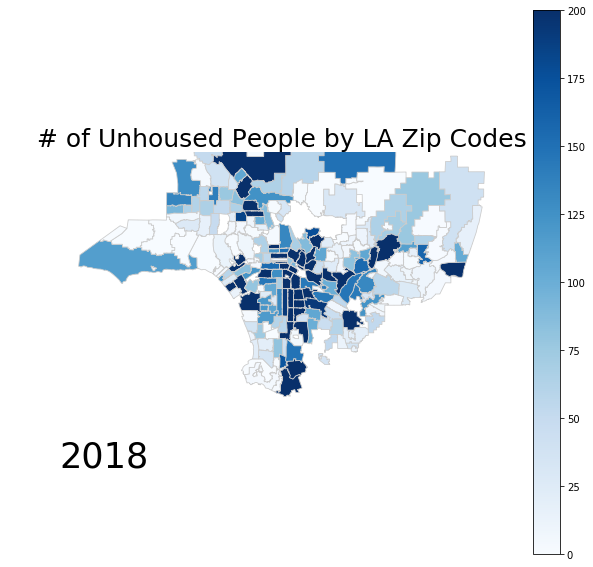

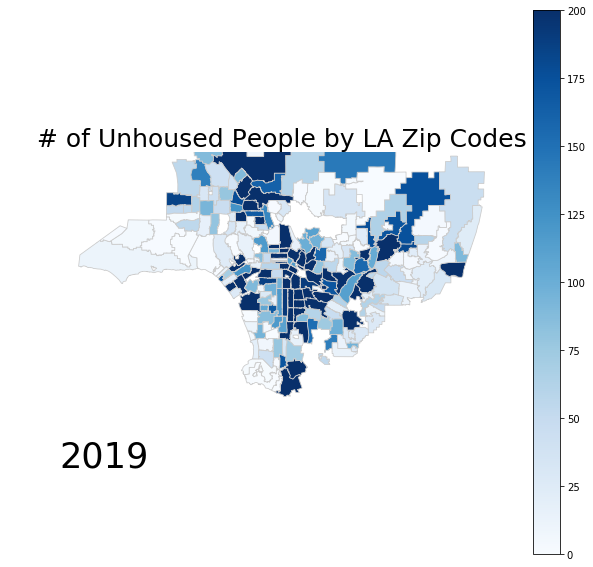

In [47]:
# start the for loop to create one map per year
for y in range(len(zipbyyear_list)):
    merged = []
    #merge with map_zip
    merged = map_zip.merge(zipbyyear_list[y], on='ZIP')
    
    # create map, UDPATE: added plt.Normalize to keep the legend range the same for all maps
    fig = merged.plot(variable, cmap='Blues', figsize=(10,10), linewidth=0.8, edgecolor='0.8', vmin=vmin, vmax=vmax, 
                      legend=True, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    
    # remove axis of chart
    fig.axis('off')
    fig.set_ylim(1700000, 1950000)
    
    # add a title
    fig.set_title('# of Unhoused People by LA Zip Codes', \
              fontdict={'fontsize': '25',
                         'fontweight' : '3'})
    fig.annotate(yearlist[y],
            xy=(0.1, .225), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=35)
    
    # this will save the figure as a high-res png in the output path. you can also save as svg if you prefer.
    fname = 'homelessbyzip_'+str(y)+'.jpg'
    chart = fig.get_figure()
    chart.savefig(fname, dpi=300)

<p>Here is a GIF of choropleth maps showing the total number of unhoused people by zipcode across Los Angeles, in most years between 2007 and 2019. Note that, though the actual numbers may go much higher, the color scale uses 200 unhoused people in a given zipcode as the upper range.</p>

![HomelessnessByZip](https://media.giphy.com/media/XDXw8AhtjT8Hu05GzV/giphy.gif "HomelessnessByZip")

In [48]:
# list of map info for tracts by years (which are the column names at the moment)
tractbyyear_list = [mapdata_2007, mapdata_2009, mapdata_2011, mapdata_2013, mapdata_2015,
                  mapdata_2016, mapdata_2017, mapdata_2018, mapdata_2019]

In [49]:
# set the min and max range for the choropleth map
v2min, v2max = 0.0, 100.0
#name variable
variable2 = 'totalUnshelteredPeopleCount'
yearlist2 = ['2007', '2009', '2011', '2013', '2015', '2016', '2017', '2018', '2019']

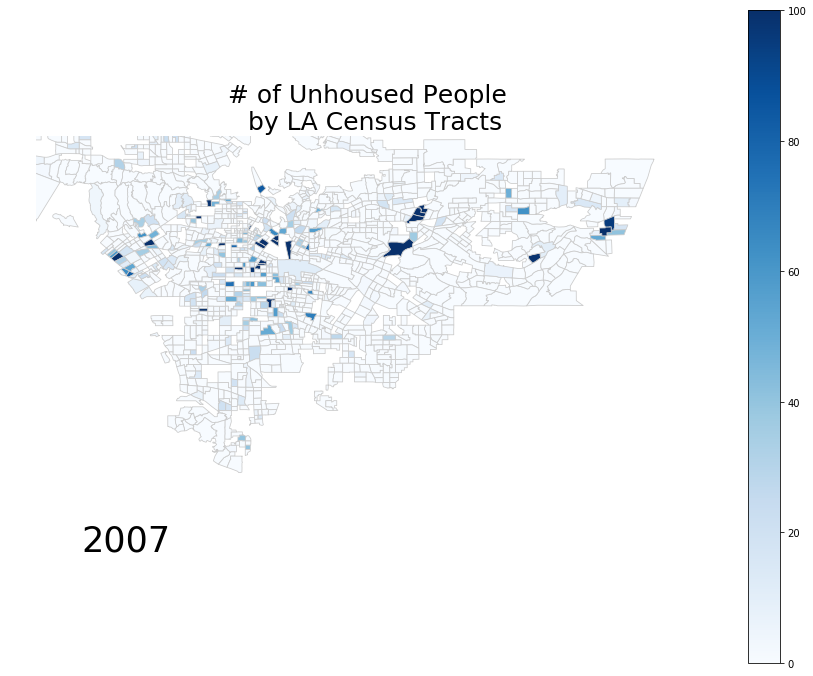

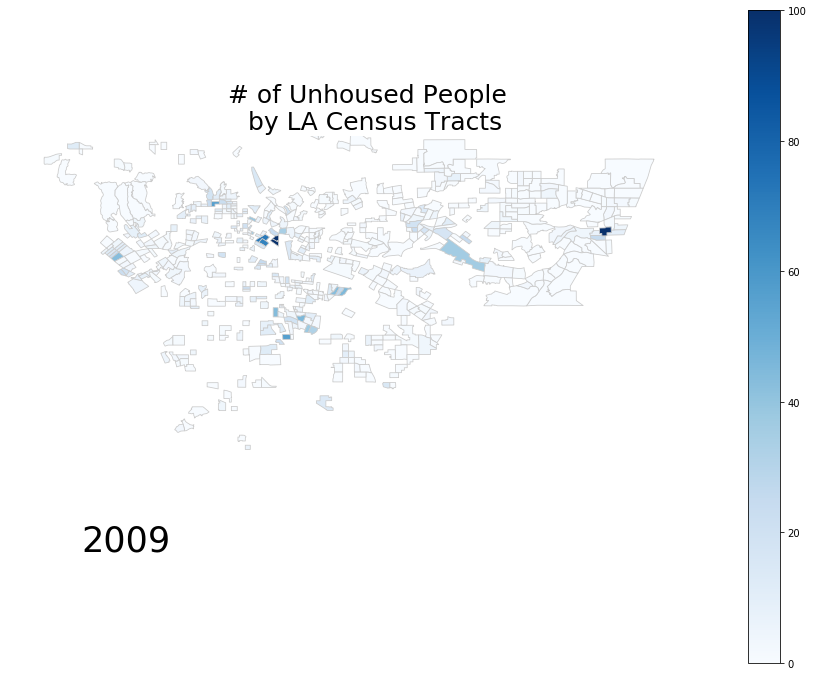

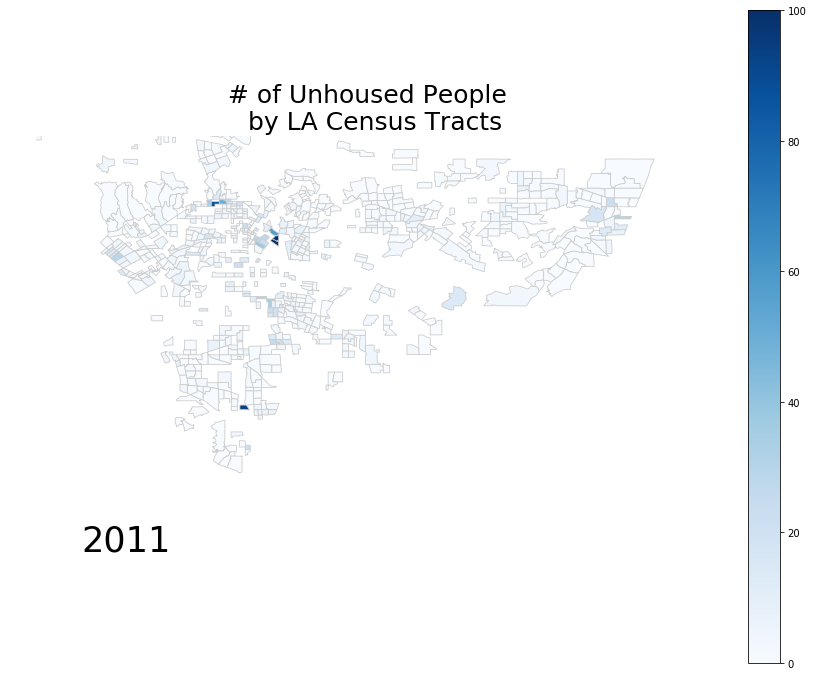

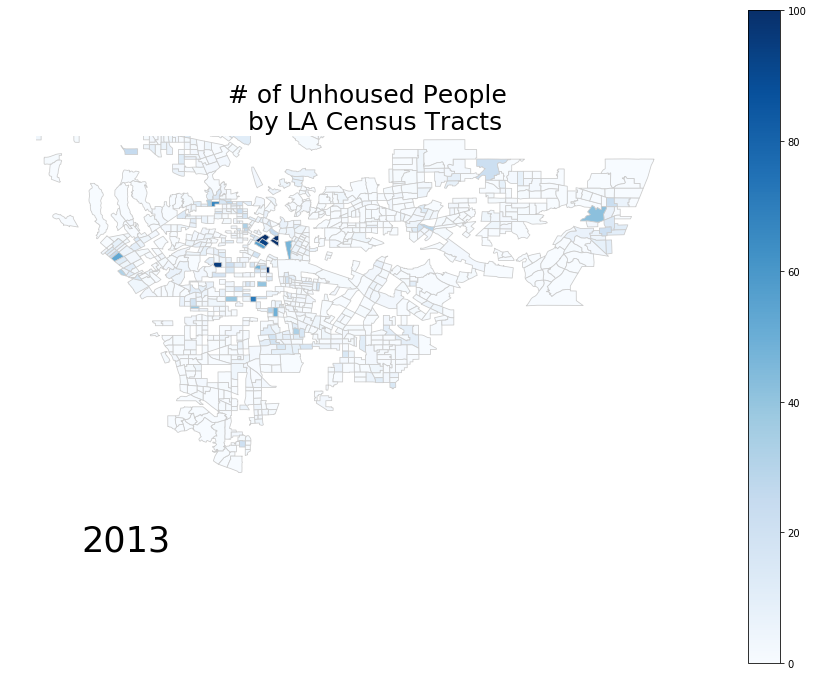

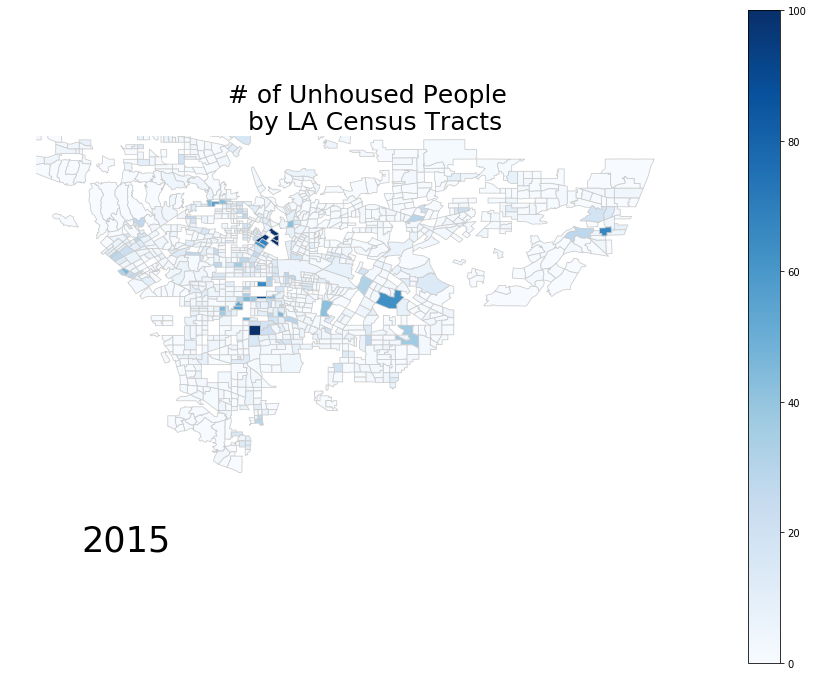

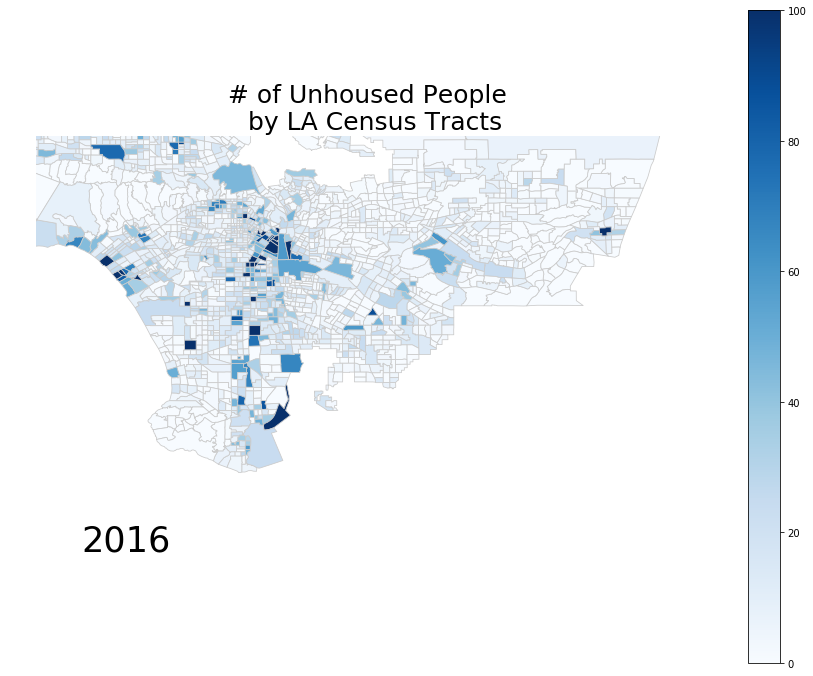

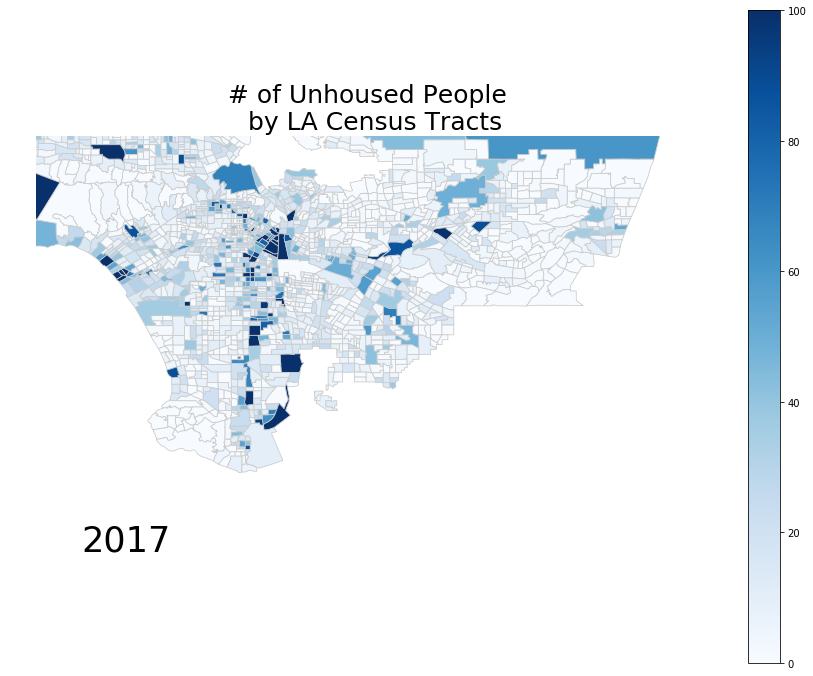

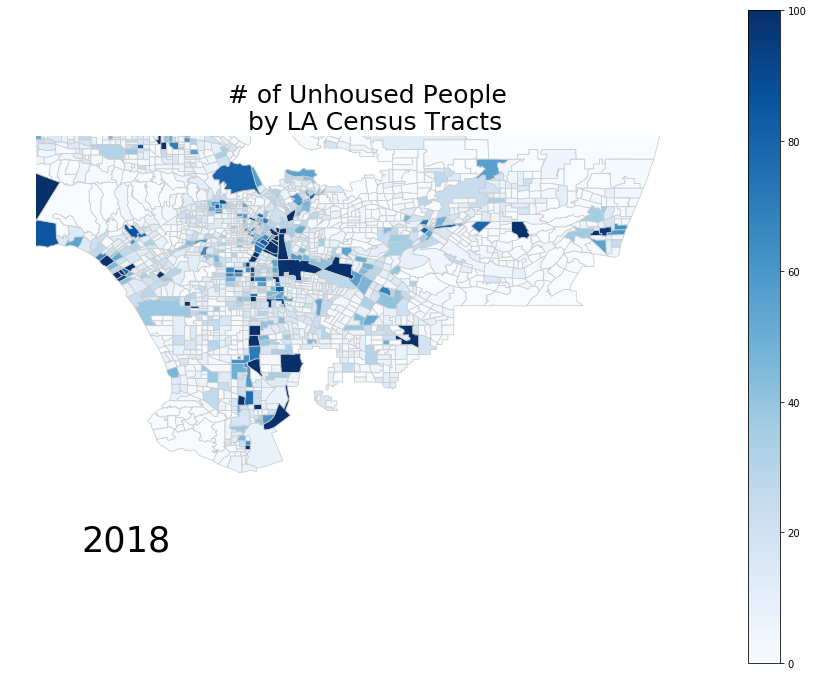

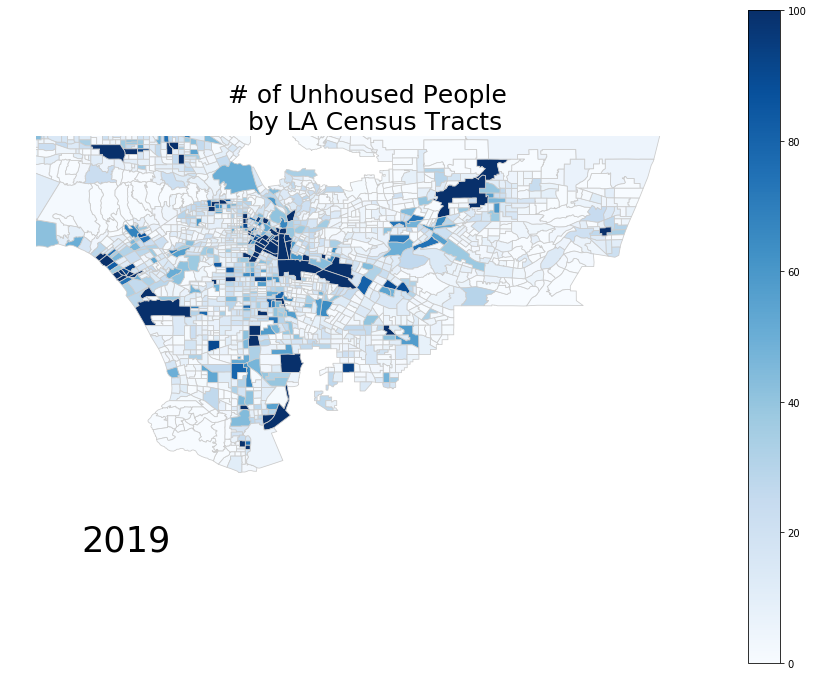

In [50]:
# start the for loop to create one map per year
for y in range(len(tractbyyear_list)):
    merged = []
    #merge with map_tract
    merged = map_census.merge(tractbyyear_list[y], on='tractNum')
    
    # create map, UDPATE: added plt.Normalize to keep the legend range the same for all maps
    fig = merged.plot(variable2, cmap='Blues', figsize=(15,12), linewidth=0.8, edgecolor='0.8', 
                      vmin=v2min, vmax=v2max, legend=True, norm=plt.Normalize(vmin=v2min, vmax=v2max))
    
    # remove axis of chart
    fig.axis('off')
    fig.set_xlim(-118.6, -117.6)
    fig.set_ylim(33.6, 34.2)
    
    # add a title
    fig.set_title('# of Unhoused People \n by LA Census Tracts', \
              fontdict={'fontsize': '25',
                         'fontweight' : '3'})
    fig.annotate(yearlist2[y],
            xy=(0.1, .225), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=35)
    
    # this will save the figure as a high-res png in the output path. you can also save as svg if you prefer.
    fname = 'homelessbytract_'+str(y)+'.jpg'
    chart = fig.get_figure()
    chart.savefig(fname, dpi=300)

<p>Here is a GIF of choropleth maps showing the total number of unhoused people by census tract across Los Angeles, in most years between 2007 and 2019. Note that, though the actual numbers may go much higher, the color scale uses 100 unhoused people in a given census tract as the upper range.</p>

![HomelessnessByTract](https://media.giphy.com/media/jTetsRJ2mUULTpf8cF/giphy.gif "HomelessnessByTract")

## Results Summary

<p>Ultimately, neither exploratory analysis nor machine learning models were able to demonstrate an obvious link between evictions and homelessness in Los Angeles, although both evictions and homelessness have reportedly <a href="https://www.huffpost.com/entry/los-angeles-evictions_n_5ccc8b02e4b0e4d757325671">increased dramatically</a> in recent years. As mentioned above, one reason that the datasets used here may not have captured a real relationship between evictions and homelessness is poor eviction record-keeping practices. Because court records for evictions can be difficult to obtain, and because many evictions may not even go through the court system at all, even the Eviction Lab's incredibly well-organized data probably doesn't capture the magnitude of evictions in Los Angeles. One way to address this issue is to consider alternative datasets, such as LAHSA's <a href="https://economicrt.org/publication/los-angeles-county-homeless-count-data-library/"> yearly demographic survey</a> of people experiencing homelessness. While this data is only a sample, and it is self-reported, there is information on causes of homelessness, as well as some information about neighborhoods where people lived before becoming homeless and where they stay after having become homeless. This information may well be a better source for understanding how evictions relate to homelessness when civic records are lacking. Demographic data may also be useful in understanding the changing face of homelessness in Los Angeles. Some of the most alarming statistics in <a href="https://www.lahsa.org/documents?id=2059-2018-greater-los-angeles-homeless-count-presentation.pdf">recent reports</a> demonstrate that homelessness is increasing among both young and elderly populations, and that women and families are also falling into homelessness at a much higher rate than in previous years. Demographic data may be another useful tool in understanding how public policy can affect homelessness.</p>
<p>Another issue with the analysis described above was the temporal delay between being evicted and becoming homeless. <a href="https://www.cbsnews.com/news/los-angeles-hidden-homeless-priced-out-cbsn-originals/">Many reports have noted</a> that Angelenos who are evicted or who simply can't afford to pay their rent are increasingly living in their cars, rather than living on the street. For future analyses of these eviction data, it may be preferable to use evictions to predict a statistic like the number of people living in vehicles in a given area. A future analysis could make use of a temporal delay between eviction data and homelessness data.</p>
<p>What the visualizations above demonstrate is that the increase in homelessness is most evident at both the census tract and the zip code level beginning in 2015, the first year that the Street Count was performed annually. Particularly in Downtown LA, East LA, Santa Monica, Venice, Baldwin Park, and Azusa, there are increasing numbers of people experiencing homelessness, and areas with dense populations of people experiencing homelessness are no longer within small, well-defined borders like Skid Row and Santa Monica. My hope is that these visualizations, if nothing else, will convince elected officials and policy-makers in Los Angeles to enact policies that are strongly and squarely aimed at preventing even more people from becoming homeless, and at mitigating an already devastating homelessness crisis.</p>